In [ ]:
import os
import numpy as np
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [ ]:
files = glob('data/MEL_augmentation/*.npy')

In [ ]:
X_list = []
labels = []

for f in files:
    S_db = np.load(f)

    X_list.append(S_db)

    emotion = os.path.basename(f).split("_")[0]
    labels.append(emotion)

X = np.array(X_list, dtype=np.float32)
print("X shape:", X.shape)


X shape: (1724, 128, 126)


In [ ]:
mean = X.mean()
std = X.std() + 1e-8
X = (X - mean) / std

X = X[..., np.newaxis]


In [ ]:
le = LabelEncoder()
y_int = le.fit_transform(labels)     # [0,1,2,...]
y = to_categorical(y_int)

print("Clases:", le.classes_)


Clases: ['Anger' 'Disgust' 'Fear' 'Happiness' 'Neutral' 'Sadness']


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y_int
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def modelo_CNN_mel(input_shape=(128, 126, 1), num_classes=6):
    model = Sequential()
    model.add(Input(shape=input_shape))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model


In [ ]:
import collections
print(collections.Counter(labels))


Counter({'Fear': 288, 'Disgust': 288, 'Happiness': 288, 'Sadness': 288, 'Neutral': 286, 'Anger': 286})


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = modelo_CNN_mel(input_shape=X_train.shape[1:], num_classes=y_train.shape[1])

es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[es],
)


Epoch 1/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.2128 - loss: 1.8378 - val_accuracy: 0.4725 - val_loss: 1.3731
Epoch 2/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4905 - loss: 1.3297 - val_accuracy: 0.6609 - val_loss: 0.9775
Epoch 3/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6444 - loss: 0.9567 - val_accuracy: 0.7188 - val_loss: 0.8173
Epoch 4/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7299 - loss: 0.7252 - val_accuracy: 0.7594 - val_loss: 0.6522
Epoch 5/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8290 - loss: 0.5341 - val_accuracy: 0.8145 - val_loss: 0.5182
Epoch 6/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8804 - loss: 0.3091 - val_accuracy: 0.8609 - val_loss: 0.4003
Epoch 7/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9062 - loss: 0.2504 - val_accuracy: 0.8406 - val_loss: 0.4344
Epoch 8/40
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9411 - loss: 0.1747 - val_accuracy: 0.9014 - v

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y_int,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42
)


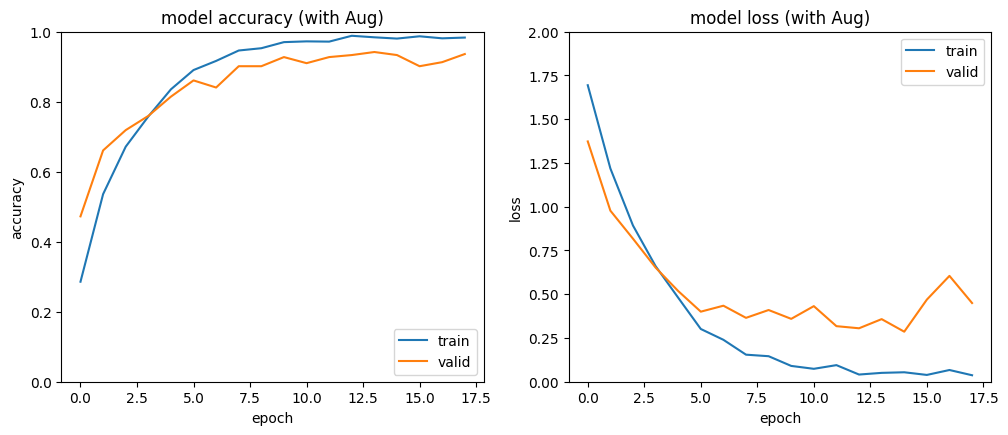

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy (with Aug)')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (with Aug)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.ylim([0, 2])

plt.show()


In [ ]:
model.save('Modelo_93-62.keras')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


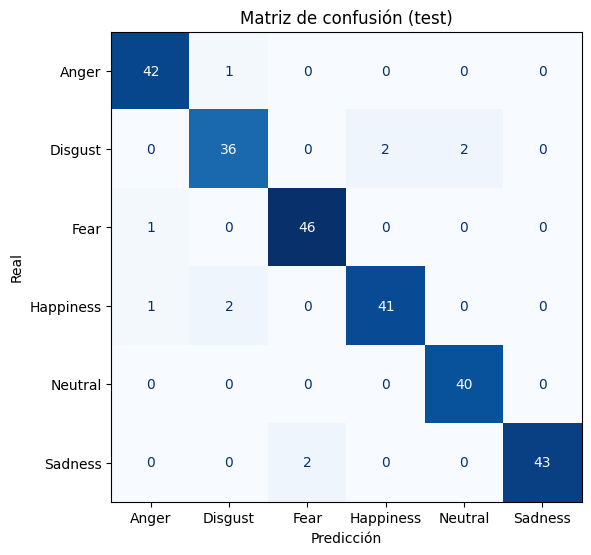

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_prob = model.predict(X_test)
y_pred_int = np.argmax(y_prob, axis=1)  # clases predichas (enteros)
y_true_int = np.argmax(y_test, axis=1)  # clases reales (enteros)

cm = confusion_matrix(y_true_int, y_pred_int)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca(), colorbar=False)
plt.title("Matriz de confusión (test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()
